In [1]:
import torch
import os
import torch.nn.functional as F
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"GPU is available! Found {gpu_count} GPU(s).")
    
    # Get the name of the primary GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Device Name: {gpu_name}")
else:
    print("No GPU available, using CPU instead.")

GPU is available! Found 1 GPU(s).
Device Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [3]:

# --- 1. Advanced GNN Architecture ---
class AdvancedGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(AdvancedGNN, self).__init__()
        
        # We use GATConv which allows nodes to weigh their neighbors' importance.
        # 'heads' parameter enables multi-head attention for more stable learning.
        self.conv1 = GATConv(num_node_features, 64, heads=8, dropout=0.6)
        self.bn1 = BatchNorm(64 * 8) # Batch Normalization
        
        # The input to the next layer is hidden_channels * heads
        self.conv2 = GATConv(64 * 8, 128, heads=1, dropout=0.6)
        self.bn2 = BatchNorm(128)
        
        self.conv3 = GATConv(128, 128, heads=1, dropout=0.6)
        self.bn3 = BatchNorm(128)

        # Classifier
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GNN layers with BatchNorm and Dropout
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x) # ELU is often used with GAT
        
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        
        # Pooling Layer
        x = global_mean_pool(x, batch)

        # Classifier
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=-1)


In [4]:

# --- 2. Dataset Class (reused) ---
class MNISTGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MNISTGraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self): return []
    @property
    def processed_file_names(self): return [f'data_{i}.pt' for i in range(60000)]
    def len(self): return len(self.processed_file_names)
    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)
        return data


In [5]:

# --- 3. Training and Testing Functions (reused) ---
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def test(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in tqdm(loader, desc="Testing"):
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)



Using device: cuda
Loading completed.
DataLoaders created.
Model initialized.


Testing: 100%|██████████| 94/94 [00:16<00:00,  5.78it/s]


Epoch: 01, Loss: 2.1868, Test Accuracy: 0.1020, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:13<00:00,  7.21it/s]


Epoch: 02, Loss: 2.1558, Test Accuracy: 0.1095, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:20<00:00,  4.48it/s]


Epoch: 03, Loss: 2.1457, Test Accuracy: 0.1511, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:21<00:00,  4.30it/s]


Epoch: 04, Loss: 2.1428, Test Accuracy: 0.1015, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:13<00:00,  6.75it/s]


Epoch: 05, Loss: 2.1375, Test Accuracy: 0.1388, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 06, Loss: 2.1339, Test Accuracy: 0.0998, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 07, Loss: 2.1337, Test Accuracy: 0.0981, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 08, Loss: 2.1268, Test Accuracy: 0.0984, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:20<00:00,  4.53it/s]


Epoch: 09, Loss: 2.1210, Test Accuracy: 0.0986, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:21<00:00,  4.31it/s]


Epoch: 10, Loss: 2.1184, Test Accuracy: 0.1001, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:21<00:00,  4.38it/s]


Epoch: 11, Loss: 2.1073, Test Accuracy: 0.0982, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:22<00:00,  4.21it/s]


Epoch: 12, Loss: 2.1105, Test Accuracy: 0.0982, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 13, Loss: 2.1032, Test Accuracy: 0.0981, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 14, Loss: 2.0994, Test Accuracy: 0.0986, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 15, Loss: 2.0949, Test Accuracy: 0.1000, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:22<00:00,  4.21it/s]


Epoch: 16, Loss: 2.0922, Test Accuracy: 0.0994, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:19<00:00,  4.74it/s]


Epoch: 17, Loss: 2.0921, Test Accuracy: 0.0983, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Epoch: 18, Loss: 2.0882, Test Accuracy: 0.0981, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 19, Loss: 2.0842, Test Accuracy: 0.1028, LR: 0.001000


Testing: 100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 20, Loss: 2.0807, Test Accuracy: 0.0992, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:16<00:00,  5.61it/s]


Epoch: 21, Loss: 2.0730, Test Accuracy: 0.1027, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:14<00:00,  6.59it/s]


Epoch: 22, Loss: 2.0719, Test Accuracy: 0.0993, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:06<00:00, 13.85it/s]


Epoch: 23, Loss: 2.0717, Test Accuracy: 0.0988, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:17<00:00,  5.41it/s]


Epoch: 24, Loss: 2.0704, Test Accuracy: 0.1003, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:20<00:00,  4.67it/s]


Epoch: 25, Loss: 2.0688, Test Accuracy: 0.1026, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:14<00:00,  6.69it/s]


Epoch: 26, Loss: 2.0714, Test Accuracy: 0.1010, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:11<00:00,  8.07it/s]


Epoch: 27, Loss: 2.0692, Test Accuracy: 0.1001, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


Epoch: 28, Loss: 2.0702, Test Accuracy: 0.1003, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:17<00:00,  5.41it/s]


Epoch: 29, Loss: 2.0671, Test Accuracy: 0.1014, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


Epoch: 30, Loss: 2.0673, Test Accuracy: 0.1021, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:10<00:00,  8.99it/s]


Epoch: 31, Loss: 2.0640, Test Accuracy: 0.0994, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:14<00:00,  6.35it/s]


Epoch: 32, Loss: 2.0661, Test Accuracy: 0.1000, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 33, Loss: 2.0670, Test Accuracy: 0.0998, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 34, Loss: 2.0608, Test Accuracy: 0.0998, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 35, Loss: 2.0621, Test Accuracy: 0.1009, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:13<00:00,  7.00it/s]


Epoch: 36, Loss: 2.0649, Test Accuracy: 0.1012, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:12<00:00,  7.26it/s]


Epoch: 37, Loss: 2.0619, Test Accuracy: 0.1006, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:13<00:00,  7.13it/s]


Epoch: 38, Loss: 2.0583, Test Accuracy: 0.1013, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:32<00:00,  2.89it/s]


Epoch: 39, Loss: 2.0630, Test Accuracy: 0.1060, LR: 0.000100


Testing: 100%|██████████| 94/94 [00:30<00:00,  3.03it/s]


Epoch: 40, Loss: 2.0607, Test Accuracy: 0.1068, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Epoch: 41, Loss: 2.0628, Test Accuracy: 0.1048, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 42, Loss: 2.0592, Test Accuracy: 0.1032, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 43, Loss: 2.0613, Test Accuracy: 0.1068, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:13<00:00,  6.80it/s]


Epoch: 44, Loss: 2.0592, Test Accuracy: 0.1069, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:13<00:00,  7.16it/s]


Epoch: 45, Loss: 2.0620, Test Accuracy: 0.1075, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Epoch: 46, Loss: 2.0559, Test Accuracy: 0.1035, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:13<00:00,  6.97it/s]


Epoch: 47, Loss: 2.0557, Test Accuracy: 0.1071, LR: 0.000010


Testing: 100%|██████████| 94/94 [01:40<00:00,  1.07s/it]


Epoch: 48, Loss: 2.0590, Test Accuracy: 0.1018, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]


Epoch: 49, Loss: 2.0571, Test Accuracy: 0.1034, LR: 0.000010


Testing: 100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 50, Loss: 2.0610, Test Accuracy: 0.1028, LR: 0.000010
Saving advanced model state...
Model saved to advanced_gnn_model.pth


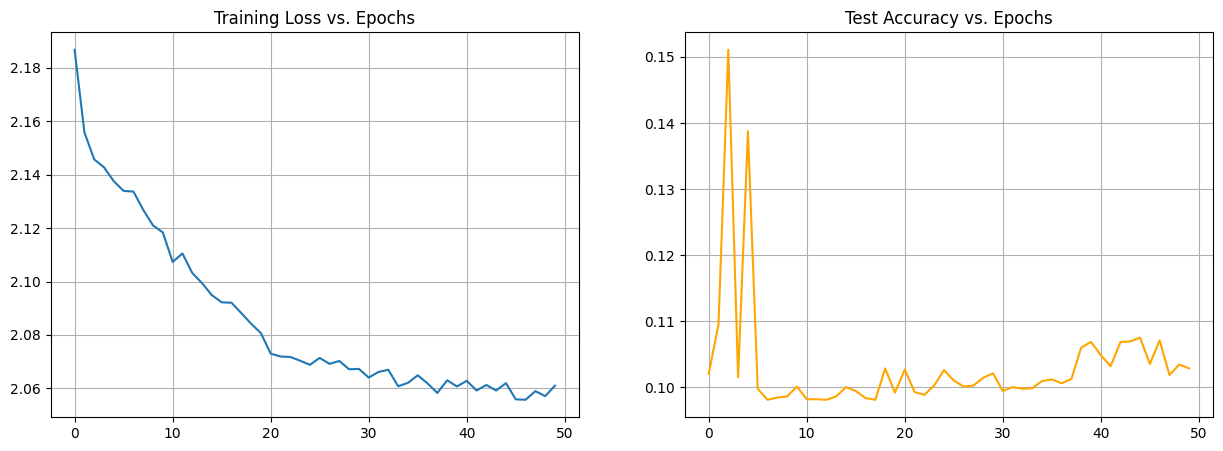

In [6]:

# --- 4. Main Execution Block ---
if __name__ == '__main__':
    # --- Hyperparameters ---
    EPOCHS = 50
    LEARNING_RATE = 0.001
    BATCH_SIZE = 128
    NUM_WORKERS = 0

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load and split dataset
    dataset = MNISTGraphDataset(root=r'A:\mnist_gnn\mnist_first_try\mnist_graphs')
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
    train_dataset = dataset[train_indices]
    test_dataset = dataset[test_indices]
    print("Loading completed.")
    # Create optimized DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    print("DataLoaders created.")
    # Initialize model
    # We know there are 3 node features and 10 digit classes(from first try) to save time
    model = AdvancedGNN(num_node_features=3, num_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1) # Reduce LR by 90% every 20 epochs
    print("Model initialized.")
    # Training loop
    history = {'loss': [], 'accuracy': []}
    for epoch in range(1, EPOCHS + 1):
        loss = train(model, train_loader, optimizer, device)
        test_acc = test(model, test_loader, device)
        scheduler.step()
        
        history['loss'].append(loss)
        history['accuracy'].append(test_acc)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

    # Save the new model
    print("Saving advanced model state...")
    torch.save(model.state_dict(), 'advanced_gnn_model.pth')
    print("Model saved to advanced_gnn_model.pth")

    # Plotting results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['loss'], label='Training Loss')
    ax1.set_title('Training Loss vs. Epochs')
    ax1.grid(True)
    ax2.plot(history['accuracy'], label='Test Accuracy', color='orange')
    ax2.set_title('Test Accuracy vs. Epochs')
    ax2.grid(True)
    plt.show()